# CLUSTERING ALGORITHM
KINBIOTICS_NER



In this notebook, we explore the clustering of symptom data extracted from the dataset using natural language processing techniques.
The main steps involved are data preprocessing, vectorization of symptoms using Word2Vec, calculating cosine similarity between symptom vectors, and applying K-Means clustering to group similar symptoms.
We evaluate the clustering performance using metrics such as Silhouette coefficient, Davies-Bouldin Score, and Calinski-Harabasz Score, aiming to determine the optimal number of clusters.
Finally, we visualize the clustering results and discuss the insights gained from the analysis.

In [3]:
# # Import necessary libraries
import pandas as pd
import numpy as np
import json

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt

In [4]:
# Load and display the dataset
df = pd.read_csv('KINBIOTICS_NER.csv')
df

,ID,text,id,label,annotator,annotation_id,created_at,updated_at,lead_time
0,30579,"Chief Complaint:\n pancreatic necrosis, sepsis...",110,"[{""start"": 2946, ""end"": 2958, ""text"": ""enteroc...",4,103,2023-01-09T12:50:16.935407Z,2023-04-27T09:12:47.685596Z,105.629
1,2165,Chief Complaint:\n anemia and rising creatinin...,187,"[{""start"": 2158, ""end"": 2165, ""text"": ""e. coli...",4,179,2023-01-09T12:56:31.788996Z,2023-01-24T11:47:14.054000Z,334.146
2,50913,"Chief Complaint:\n fever, abdominal pain, hypo...",179,"[{""start"": 18, ""end"": 23, ""text"": ""fever"", ""la...",4,171,2023-01-09T12:55:53.949142Z,2023-01-24T11:40:31.894971Z,37.923
3,91525,Chief Complaint:\n rigors\n\nHistory of Presen...,173,"[{""start"": 1365, ""end"": 1375, ""text"": ""klebsie...",4,166,2023-01-09T12:55:25.402331Z,2023-01-24T11:39:07.485209Z,57.279
4,54757,"Chief Complaint:\n fevers, bacteremia\n\nHisto...",171,"[{""start"": 18, ""end"": 24, ""text"": ""fevers"", ""l...",4,164,2023-01-09T12:55:19.594235Z,2023-01-24T11:37:58.799081Z,44.431
...,...,...,...,...,...,...,...,...,...
367,21990,"Chief Complaint:\n fever, altered mental statu...",117,"[{""start"": 1498, ""end"": 1502, ""text"": ""mrsa"", ...",4,110,2023-01-09T12:50:45.574544Z,2023-01-09T12:50:45.574577Z,2.027
368,49247,"Chief Complaint:\n dyspnea, chest pain\n\nHist...",114,"[{""start"": 18, ""end"": 25, ""text"": ""dyspnea"", ""...",4,107,2023-01-09T12:50:35.990120Z,2023-01-09T12:50:35.990159Z,1.647
369,6930,Chief Complaint:\n fever\n\nHistory of Present...,108,"[{""start"": 18, ""end"": 23, ""text"": ""fever"", ""la...",4,101,2023-01-09T12:49:48.429080Z,2023-01-09T12:49:48.429113Z,2.319
370,11050,"Chief Complaint:\n fever, abd pain\n\nHistory ...",101,"[{""start"": 18, ""end"": 23, ""text"": ""fever"", ""la...",4,94,2023-01-09T12:48:40.440134Z,2023-01-09T12:48:40.440163Z,14.887


In [5]:
first_entity = df.at[0, 'label']
print(first_entity)

[{"start": 2946, "end": 2958, "text": "enterococcus", "labels": ["Pathogen"]}, {"start": 18, "end": 37, "text": "pancreatic necrosis", "labels": ["Symptom"]}, {"start": 39, "end": 45, "text": "sepsis", "labels": ["Symptom"]}, {"start": 47, "end": 66, "text": "respiratory failure", "labels": ["Symptom"]}, {"start": 151, "end": 175, "text": "necrotizing pancreatitis", "labels": ["Symptom"]}, {"start": 199, "end": 218, "text": "respiratory failure", "labels": ["Symptom"]}, {"start": 220, "end": 230, "text": "bacteremia", "labels": ["Symptom"]}, {"start": 291, "end": 302, "text": "hypotension", "labels": ["Symptom"]}, {"start": 627, "end": 651, "text": "necrotizing pancreatitis", "labels": ["Symptom"]}, {"start": 728, "end": 733, "text": "shock", "labels": ["Symptom"]}, {"start": 735, "end": 754, "text": "respiratory failure", "labels": ["Symptom"]}, {"start": 988, "end": 999, "text": "hypotension", "labels": ["Symptom"]}, {"start": 1025, "end": 1038, "text": "mild diarrhea", "labels": ["S

In [6]:

# Symptoms extraction
def extract_symptoms(row):
    symptoms = []
    try:
        labels = json.loads(row['label'])
        for item in labels:
            if 'Symptom' in item['labels']:
                symptoms.append(item['text'])
    except (TypeError, ValueError):
        pass
    return symptoms

# Pathogens extraction
def extract_pathogens(row):
    pathogens = []
    try:
        labels = json.loads(row['label'])
        for item in labels:
            if 'Pathogen' in item['labels']:
                pathogens.append(item['text'])
    except (TypeError, ValueError):
        pass
    return pathogens

# Creations of the new columns "Symptoms" and "Pathogen"
df['Symptoms'] = df.apply(extract_symptoms, axis=1)
df['Pathogen'] = df.apply(extract_pathogens, axis=1)

# Conversion of symptom and pathogen lists into comma-separated strings
df['Symptoms'] = df['Symptoms'].apply(lambda x: ', '.join(x))
df['Pathogen'] = df['Pathogen'].apply(lambda x: ', '.join(x))

# Visualisation of the new DataFrame
print(df)


        ID                                               text   id  \
0    30579  Chief Complaint:\n pancreatic necrosis, sepsis...  110   
1     2165  Chief Complaint:\n anemia and rising creatinin...  187   
2    50913  Chief Complaint:\n fever, abdominal pain, hypo...  179   
3    91525  Chief Complaint:\n rigors\n\nHistory of Presen...  173   
4    54757  Chief Complaint:\n fevers, bacteremia\n\nHisto...  171   
..     ...                                                ...  ...   
367  21990  Chief Complaint:\n fever, altered mental statu...  117   
368  49247  Chief Complaint:\n dyspnea, chest pain\n\nHist...  114   
369   6930  Chief Complaint:\n fever\n\nHistory of Present...  108   
370  11050  Chief Complaint:\n fever, abd pain\n\nHistory ...  101   
371  19533  Chief Complaint:\n abdominal pain nausea/vomit...   97   

                                                 label  annotator  \
0    [{"start": 2946, "end": 2958, "text": "enteroc...          4   
1    [{"start": 2158,

In [7]:
df

,ID,text,id,label,annotator,annotation_id,created_at,updated_at,lead_time,Symptoms,Pathogen
0,30579,"Chief Complaint:\n pancreatic necrosis, sepsis...",110,"[{""start"": 2946, ""end"": 2958, ""text"": ""enteroc...",4,103,2023-01-09T12:50:16.935407Z,2023-04-27T09:12:47.685596Z,105.629,"pancreatic necrosis, sepsis, respiratory failu...","enterococcus, cns"
1,2165,Chief Complaint:\n anemia and rising creatinin...,187,"[{""start"": 2158, ""end"": 2165, ""text"": ""e. coli...",4,179,2023-01-09T12:56:31.788996Z,2023-01-24T11:47:14.054000Z,334.146,"anemia, rising creatinine, anemic, 1 month of ...","e. coli, e coli, citrobacter, citrobacter, gnr..."
2,50913,"Chief Complaint:\n fever, abdominal pain, hypo...",179,"[{""start"": 18, ""end"": 23, ""text"": ""fever"", ""la...",4,171,2023-01-09T12:55:53.949142Z,2023-01-24T11:40:31.894971Z,37.923,"fever, abdominal pain, hypotension, intermitte...",
3,91525,Chief Complaint:\n rigors\n\nHistory of Presen...,173,"[{""start"": 1365, ""end"": 1375, ""text"": ""klebsie...",4,166,2023-01-09T12:55:25.402331Z,2023-01-24T11:39:07.485209Z,57.279,"rigors, chills, rigors, sweats, appetite recen...","klebsiella, enterococcus, enterococcus, entero..."
4,54757,"Chief Complaint:\n fevers, bacteremia\n\nHisto...",171,"[{""start"": 18, ""end"": 24, ""text"": ""fevers"", ""l...",4,164,2023-01-09T12:55:19.594235Z,2023-01-24T11:37:58.799081Z,44.431,"fevers, bacteremia, cholangiocarcinoma, anasta...",pan-sensitive enterococcus faecalis
...,...,...,...,...,...,...,...,...,...,...,...
367,21990,"Chief Complaint:\n fever, altered mental statu...",117,"[{""start"": 1498, ""end"": 1502, ""text"": ""mrsa"", ...",4,110,2023-01-09T12:50:45.574544Z,2023-01-09T12:50:45.574577Z,2.027,"fever, altered mental status, fever, altered m...","mrsa, coag negative staph, corynebacerium"
368,49247,"Chief Complaint:\n dyspnea, chest pain\n\nHist...",114,"[{""start"": 18, ""end"": 25, ""text"": ""dyspnea"", ""...",4,107,2023-01-09T12:50:35.990120Z,2023-01-09T12:50:35.990159Z,1.647,"dyspnea, chest pain, dyspnea, abdominal pain, ...",
369,6930,Chief Complaint:\n fever\n\nHistory of Present...,108,"[{""start"": 18, ""end"": 23, ""text"": ""fever"", ""la...",4,101,2023-01-09T12:49:48.429080Z,2023-01-09T12:49:48.429113Z,2.319,"fever, sternal wound drainage, rash, fevers, m...",methicillin sensitive staph aureus
370,11050,"Chief Complaint:\n fever, abd pain\n\nHistory ...",101,"[{""start"": 18, ""end"": 23, ""text"": ""fever"", ""la...",4,94,2023-01-09T12:48:40.440134Z,2023-01-09T12:48:40.440163Z,14.887,"fever, abd pain, intractable abdominal pain, n...",


In [8]:
# Dataframe expansion in order to have a single symptom in each row
expanded_rows = []
for index, row in df.iterrows():
    symptoms = row['Symptoms'].split(', ')
    for symptom in symptoms:
        expanded_row = row.copy()
        expanded_row['Symptoms'] = symptom
        expanded_rows.append(expanded_row)

expanded_df = pd.DataFrame(expanded_rows)

print(expanded_df)

        ID                                               text   id  \
0    30579  Chief Complaint:\n pancreatic necrosis, sepsis...  110   
0    30579  Chief Complaint:\n pancreatic necrosis, sepsis...  110   
0    30579  Chief Complaint:\n pancreatic necrosis, sepsis...  110   
0    30579  Chief Complaint:\n pancreatic necrosis, sepsis...  110   
0    30579  Chief Complaint:\n pancreatic necrosis, sepsis...  110   
..     ...                                                ...  ...   
371  19533  Chief Complaint:\n abdominal pain nausea/vomit...   97   
371  19533  Chief Complaint:\n abdominal pain nausea/vomit...   97   
371  19533  Chief Complaint:\n abdominal pain nausea/vomit...   97   
371  19533  Chief Complaint:\n abdominal pain nausea/vomit...   97   
371  19533  Chief Complaint:\n abdominal pain nausea/vomit...   97   

                                                 label  annotator  \
0    [{"start": 2946, "end": 2958, "text": "enteroc...          4   
0    [{"start": 2946,

In [9]:
expanded_df

,ID,text,id,label,annotator,annotation_id,created_at,updated_at,lead_time,Symptoms,Pathogen
0,30579,"Chief Complaint:\n pancreatic necrosis, sepsis...",110,"[{""start"": 2946, ""end"": 2958, ""text"": ""enteroc...",4,103,2023-01-09T12:50:16.935407Z,2023-04-27T09:12:47.685596Z,105.629,pancreatic necrosis,"enterococcus, cns"
0,30579,"Chief Complaint:\n pancreatic necrosis, sepsis...",110,"[{""start"": 2946, ""end"": 2958, ""text"": ""enteroc...",4,103,2023-01-09T12:50:16.935407Z,2023-04-27T09:12:47.685596Z,105.629,sepsis,"enterococcus, cns"
0,30579,"Chief Complaint:\n pancreatic necrosis, sepsis...",110,"[{""start"": 2946, ""end"": 2958, ""text"": ""enteroc...",4,103,2023-01-09T12:50:16.935407Z,2023-04-27T09:12:47.685596Z,105.629,respiratory failure,"enterococcus, cns"
0,30579,"Chief Complaint:\n pancreatic necrosis, sepsis...",110,"[{""start"": 2946, ""end"": 2958, ""text"": ""enteroc...",4,103,2023-01-09T12:50:16.935407Z,2023-04-27T09:12:47.685596Z,105.629,necrotizing pancreatitis,"enterococcus, cns"
0,30579,"Chief Complaint:\n pancreatic necrosis, sepsis...",110,"[{""start"": 2946, ""end"": 2958, ""text"": ""enteroc...",4,103,2023-01-09T12:50:16.935407Z,2023-04-27T09:12:47.685596Z,105.629,respiratory failure,"enterococcus, cns"
...,...,...,...,...,...,...,...,...,...,...,...
371,19533,Chief Complaint:\n abdominal pain nausea/vomit...,97,"[{""start"": 18, ""end"": 32, ""text"": ""abdominal p...",4,90,2023-01-09T12:48:02.704615Z,2023-01-09T12:48:02.704685Z,580.473,diarrhea,
371,19533,Chief Complaint:\n abdominal pain nausea/vomit...,97,"[{""start"": 18, ""end"": 32, ""text"": ""abdominal p...",4,90,2023-01-09T12:48:02.704615Z,2023-01-09T12:48:02.704685Z,580.473,hypotensive,
371,19533,Chief Complaint:\n abdominal pain nausea/vomit...,97,"[{""start"": 18, ""end"": 32, ""text"": ""abdominal p...",4,90,2023-01-09T12:48:02.704615Z,2023-01-09T12:48:02.704685Z,580.473,fever,
371,19533,Chief Complaint:\n abdominal pain nausea/vomit...,97,"[{""start"": 18, ""end"": 32, ""text"": ""abdominal p...",4,90,2023-01-09T12:48:02.704615Z,2023-01-09T12:48:02.704685Z,580.473,emesis,


In [10]:
# Create a new DataFrame with unique symptoms; this will be the starting point for the clustering part
unique_symptoms_df = expanded_df[['Symptoms']].drop_duplicates().reset_index(drop=True)
unique_symptoms_df

,Symptoms
0,pancreatic necrosis
1,sepsis
2,respiratory failure
3,necrotizing pancreatitis
4,bacteremia
...,...
1911,intractable abdominal pain
1912,yellowish loose/watery stool
1913,rim-enhancing fulid collection
1914,prevented her from eating


In [11]:
# Get the list of all symptoms
all_symptoms_list = unique_symptoms_df['Symptoms'].tolist()
for symptom in all_symptoms_list:
    print(symptom)

pancreatic necrosis
sepsis
respiratory failure
necrotizing pancreatitis
bacteremia
hypotension
shock
mild diarrhea
abdominal pain
acutely tachypneic
tachycardic
tachypneic
hypotensive
not responsive to aggressive ivf resuscitation
ischemic ekg changes
troponin leak
mild global rv systloic function
prolonged ileus
fevers
septic shock
 hypoxic respiratory failure
cardiac ischemia
anemia
rising creatinine
anemic
1 month of decreased appetite
intermittent lower abdominal pain
intermittent sharp luq abdominal pain
cough
fatigue
weakness
decreased appetite
difficulty swallowing
lightheadedness
luq pain
subjective weight loss
acute renal failure
respiratory distress
continued acute renal failure
pneumonia
new fevers
re-current pnuemonia
urinary tract infection
line infection
colitis,
acalculous cholecystitis
acute renal faliure
altered mental status
arf
bilateral effusions
pna
recurrent sepsis
medabolic acidosis
thrombocytopenia
coagulopathy
coagulation
mental status changes
hypoxia
sob
fever

# DATA PREPROCESSING
This code preprocesses symptom data and calculates cosine similarity between symptom vectors.\
After preprocessing the symptom data, it trains a Word2Vec model to generate vector representations for each symptom.\
The **Word2Vec** model is a deep learning algorithm capable of efficiently capturing the semantic meaning of words and their relationships.
In practice, it converts words into vectors of real numbers, called *word embeddings*, which then capture the semantic features of words and represent them in a vector space.\
Subsequently, these word vectors obtained from the Word2Vec model are used to calculate the similarity between symptom vectors using **cosine similarity**.
This measure provides an estimate of how two words are semantically similar based on the direction and length of their vectors in their vector space.

In [12]:
# Train the Word2Vec model on symptoms data
word2vec_model = Word2Vec(sentences=[[str(i)] for i in range(len(all_symptoms_list))], vector_size=100, window=5, min_count=1, sg=1)

# Calculate the average vector representation for each symptom
symptoms_vectors = []
for i in range(len(all_symptoms_list)):
    word = str(i)
    if word in word2vec_model.wv:
        vectors = word2vec_model.wv[word]
        symptoms_vectors.append(vectors)
    else:
        # If there are no vectors for this symptom, create a zero vector
        symptoms_vectors.append(np.zeros(word2vec_model.vector_size))

# Convert the list of vectors into a numpy array
symptoms_vectors = np.array(symptoms_vectors)

# Calculate the cosine similarity between symptom vectors
cosine_similarities = cosine_similarity(symptoms_vectors)


# Clustering evaluation

To select the optimal number of clusters obtained from the K-Means algorithm, three metrics were considered:

**Silhouette score**: This metric measures the cohesion within clusters and the separation between clusters. A value closer to 1 indicates that samples are correctly assigned to the cluster.\
**Davies-Bouldin Score**: This metric evaluates the compactness of clusters and the separation between them. A lower value indicates a better partition, where clusters are compact and separated.\
**Calinski-Harabasz Score**: This metric assesses the intra-cluster dispersion compared to the inter-cluster dispersion. A higher value indicates a better cluster structure.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

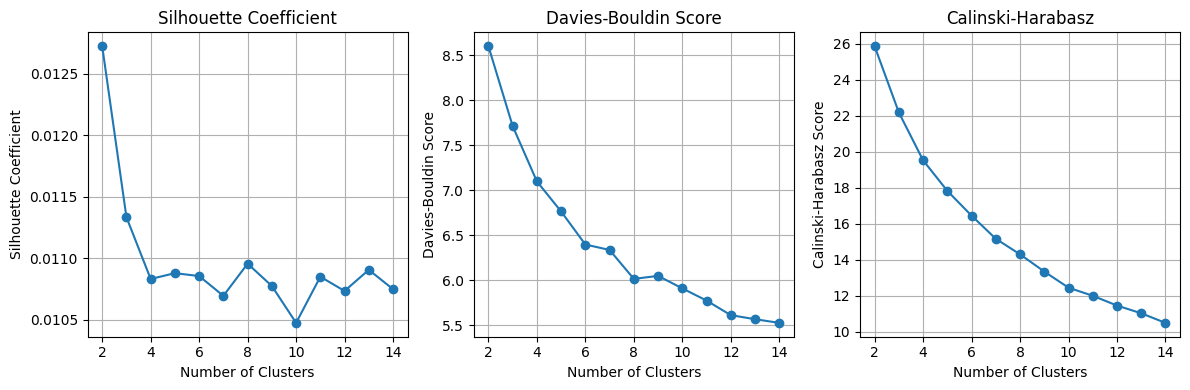

In [13]:
# Calculate the three metrics for different numbers of clusters
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

possible_num_clusters = range(2, 15)  # Try from 2 to 14 clusters
for num_clusters in possible_num_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(cosine_similarities)  # Here, we should use the similarities calculated for symptoms_df

    silhouette_scores.append(silhouette_score(cosine_similarities, cluster_labels))  # Here, we should use the similarities calculated for symptoms_df
    davies_bouldin_scores.append(davies_bouldin_score(cosine_similarities, cluster_labels))  # Here, we should use the similarities calculated for symptoms_df
    calinski_harabasz_scores.append(calinski_harabasz_score(cosine_similarities, cluster_labels))  # Here, we should use the similarities calculated for symptoms_df

# Visualization of the plots for different metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(possible_num_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(possible_num_clusters, davies_bouldin_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(possible_num_clusters, calinski_harabasz_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz')
plt.grid(True)

plt.tight_layout()
plt.show()


Taking into account the three metrics (Silhouette, Davies-Bouldin, and Calinski) and considering the premises made earlier, it seems that the most appropriate number of clusters is 8.

# Clustering

To perform clustering, we chose to use the K-Means algorithm, which groups data based on their similarity.

1. **Initialization of centroids**: The first step involves randomly selecting K points in the dataset as initial centroids, which are the initial centers of each cluster.
2. **Assignment of points to the nearest cluster**: For each point in the dataset, its distance from each centroid is calculated, and the point is assigned to the cluster whose centroid is closest to it.
3. **Recalculation of centroids**: Once all points have been assigned to clusters, the centroids are recalculated for each cluster.
4. **Iteration until Convergence**: The previous steps are repeated until the centroids do not change significantly or until a maximum number of predefined iterations is reached.

In [21]:
# Numero ottimale di cluster (scegli quello che meglio si adatta ai tuoi dati)
optimal_num_clusters = 11

# Applica KMeans con il numero ottimale di cluster
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(cosine_similarities)

# Visualizza le etichette dei cluster
print(cluster_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 5  4 10 ...  2  5  0]


In observing the count of elements in each cluster, it can be noticed that they are numerically homogeneous

In [22]:
# Count the number of elements in each cluster
cluster_counts = pd.Series(cluster_labels).value_counts()
cluster_counts_sorted = cluster_counts.sort_index()

print(cluster_counts_sorted)


0     193
1     186
2     154
3     160
4     187
5     164
6     177
7     171
8     177
9     173
10    174
dtype: int64


In [23]:
# Create a dictionary to associate symptom indices with their respective clusters
symptoms_per_cluster = {}
for cluster_label in range(optimal_num_clusters):
    symptoms_per_cluster[cluster_label] = []

for i, label in enumerate(cluster_labels):
    symptoms_per_cluster[label].append(i)

# Print the list of symptoms for each cluster
for cluster_label, symptoms in symptoms_per_cluster.items():
    print(f"Cluster {cluster_label}:")
    for symptom_index in symptoms:
        print(all_symptoms_list[symptom_index])
    print("\n")


Cluster 0:
luq pain
pancytopenia
anastamoses
significantly worsened synthetic function of his liver
tenderness
encephalopathy
recurrent rul/rml pneumonia
severe sepsis
 become dyspneic
fevers,
sore throat
bandemia
grimace with abd pain
bilateral pleural effusions
hemorrhoids
associated pleuritic chest pain
diffuse thick dark yellow secretions
agitation
increased agitation and confussion
head turning and upper extremity shaking
pain with eye and neck movement
hemodialysis line was found to be not working
chronic severe abdominal pain
delerium
 prevertebral abscess
cholestatic hepatitis
 anemia
cryptogenic cirrhosis
bleeding
emodynamic instability
sleepy
multiple non-healing ulcers
mass on anterior mitral valve leaflet
foul smelling urine
tardive dyskinesia
worsening chest ct
worse with touch or movement
radiation fibrosis
mets to brain/lung
flu
maroon stools
ercp
mild hypotension
not feeling well
nstemi
abscess in lung
dysphagia
infectious process
feel worse
sinus tachycardia
coughed up

In [27]:
# Choose the cluster of your interest
cluster_of_interest = 3
symptoms_in_cluster = [i for i, label in enumerate(cluster_labels) if label == cluster_of_interest]
print(f"Sintomi nel cluster {cluster_of_interest}:")
for symptom_index in symptoms_in_cluster:
    print(all_symptoms_list[symptom_index])


Sintomi nel cluster 3:
necrotizing pancreatitis
mild diarrhea
fevers
cardiac ischemia
anemic
re-current pnuemonia
coagulation
vomiting
chills
uncompromised perfusion
pulmonary
coughs
 rt back pain
urospesis
low uo
cardiac stress test
desaturation
low grade fever
worsening sob
mental status had significantly worsened
febrile
increased lft's
two heel ulcers
left flank pain
lymphocele
increased sob
prevertebral abscess
copd
acute cerebellar hemorrhage
arm hematoma
rash
rectus sheath hematoma
uti
equivocal peripancreatic stranding
hypoxic respiratory failure
altered
urosepsis
urethral lesion
known infiltrates on chest ct
progressive hypoxia
eg is more swollen
increase in her chronic vaginal discharge
mets to the brain and lung
resp distress
right sided nephrolithiasis
chronic gi bleeding
not responsive
unresponsive
utis
severe
acute lower extremity ischemia
fluctuance over her eythematous right knee
 acute renal failure
sinus tenderness
too tired to leave the house
occasional cough at nigh

Although 8 seems to be the optimal number of clusters to consider, experimenting with a higher number yields better and more cohesive results within each cluster, despite the decrease in Calinski's index as the number of clusters increases. For instance, considering 11 clusters, we can observe the following:

Cluster 0 predominantly contains **gastrointestinal issues**, such as LUQ pain, chronic severe abdominal pain, RUQ pain, bright red blood, onset of jaundice, and bilious emesis.
Cluster 1 is primarily characterized by **cardiovascular problems**, including thoracoabdominal aortic aneurysm, peripheral edema, decreased blood pressure, severe mitral regurgitation, and ECG abnormalities.
Cluster 2 is dominated by **pulmonary issues**, such as shortness of breath, aspiration pneumonia, pneumonitis, pseudomonal pneumonia, and RML pneumonia.
Cluster 3 mainly exhibits **renal problems**, such as an increase in creatinine value on labs, low uo, urosepsis, rt back pain, left flank pain, and urethral lesion.
Continuing with the analysis, it was observed that each cluster predominantly features similar symptoms, such as **pancreatic, neurological, metabolic, hematological, and infectious issues**. Additionally, **general symptoms** like nausea, fever, fatigue, drowsiness, and cough are recurrent across all clusters.